2025/04/20 20:52:01 INFO mlflow.tracking.fluent: Experiment with name 'random_forest_final' does not exist. Creating a new experiment.


Early stopping en 80 árboles. Mejor accuracy CV: 0.9611 con 50 árboles.


2025/04/20 20:52:01 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

2025/04/20 20:52:21 WARNING mlflow.models.model: Model logged without a signature and input example. Ple

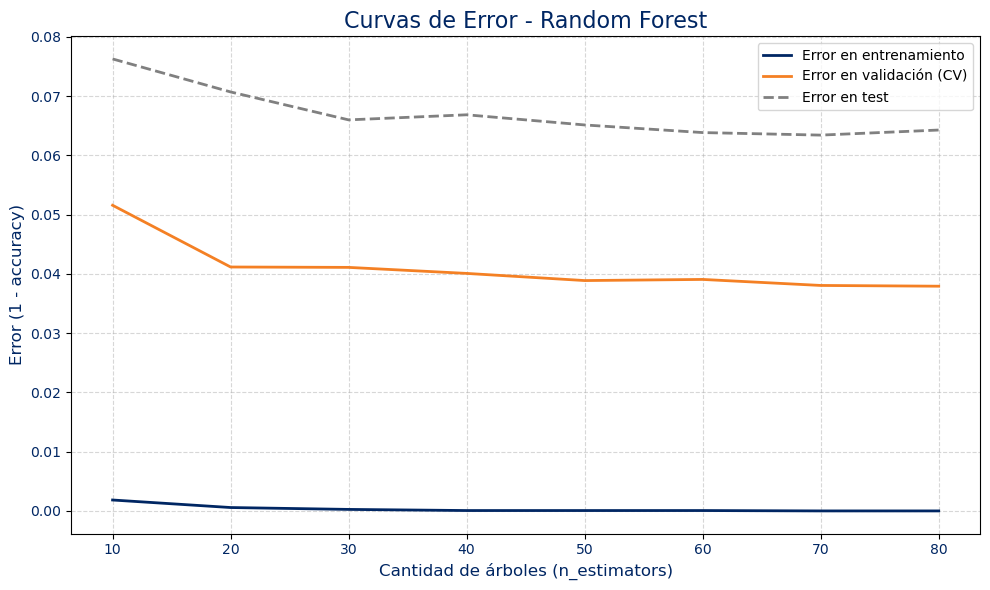

C:\Users\agust\AppData\Local\Temp\ipykernel_4432\3307602134.py:130: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  disp.plot(ax=ax, cmap=plt.cm.get_cmap('Oranges'), colorbar=False)


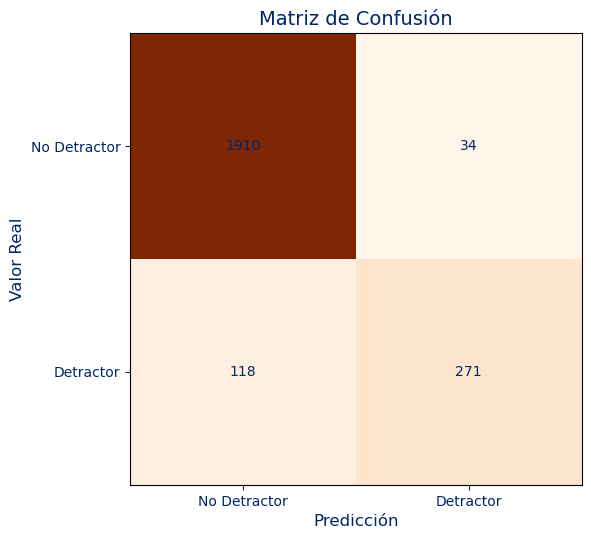


Reporte de clasificación:

              precision    recall  f1-score   support

No Detractor       0.94      0.98      0.96      1944
   Detractor       0.89      0.70      0.78       389

    accuracy                           0.93      2333
   macro avg       0.92      0.84      0.87      2333
weighted avg       0.93      0.93      0.93      2333



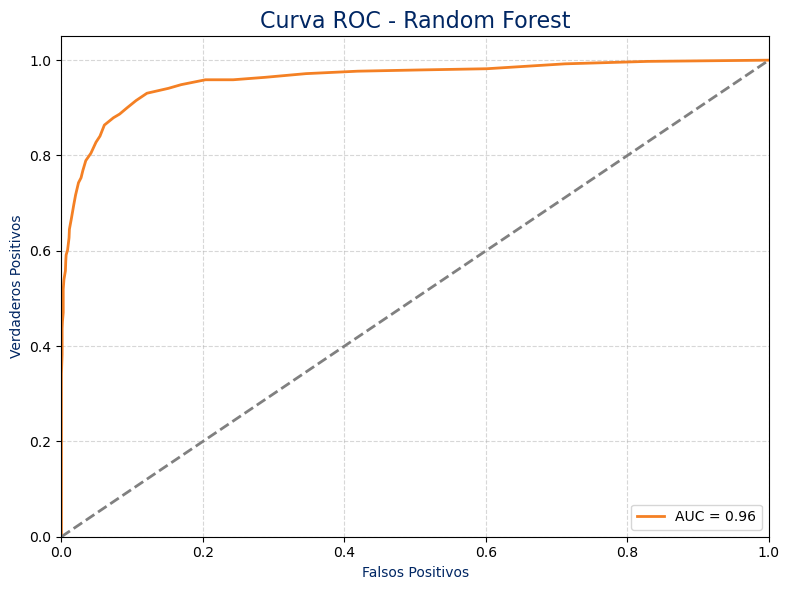

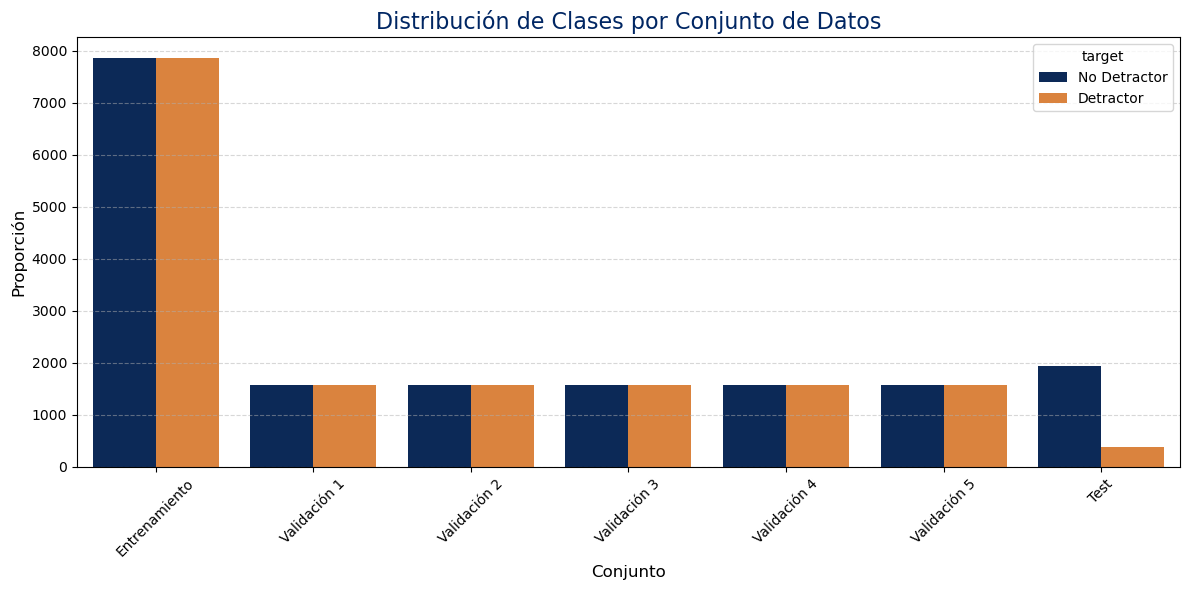

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    RocCurveDisplay,
    classification_report
)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # División del dataset
import matplotlib.pyplot as plt # Plotear
from sklearn.linear_model import LinearRegression # Modelo de ML
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix # Métricas
pd.options.display.max_columns= None
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import mlflow
import mlflow.sklearn


df = pd.read_csv('base_final_PCA.csv', delimiter= ';')
x = df.drop(['detractor'], axis=1)
y = df['detractor']



x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(x, y,
                                   random_state=104,
                                   test_size=0.20,
                                   shuffle=True)
#OverSampling:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)
x_train_rf, y_train_rf = sm.fit_resample(x_train_rf, y_train_rf)




# --- Parámetros de early stopping ---
n_estimators_range = range(10, 510, 10)
patience = 3
tolerance = 0.001

# --- Almacenar resultados ---
train_errors = []
val_errors = []
test_errors = []

best_score = 0
best_n = 10
counter = 0



# --- Early stopping loop ---
for n in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n, random_state=50, class_weight={0:1,1:6})
    rf.fit(x_train_rf, y_train_rf)

    train_acc = rf.score(x_train_rf, y_train_rf)
    train_errors.append(1 - train_acc)

    val_acc = cross_val_score(rf, x_train_rf, y_train_rf, cv=5).mean()
    val_errors.append(1 - val_acc)

    test_acc = rf.score(x_test_rf, y_test_rf)
    test_errors.append(1 - test_acc)

    if val_acc > best_score + tolerance:
        best_score = val_acc
        best_n = n
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stopping en {n} árboles. Mejor accuracy CV: {best_score:.4f} con {best_n} árboles.")
        break

# --- Entrenar modelo final ---
mlflow.set_experiment("random_forest_final")
with mlflow.start_run():
    rf_final = RandomForestClassifier(n_estimators=best_n, random_state=50, class_weight={0:1,1:6})
    rf_final.fit(x_train_rf, y_train_rf)
    y_pred = rf_final.predict(x_test_rf)
    y_prob = rf_final.predict_proba(x_test_rf)[:, 1]
    mlflow.sklearn.log_model(rf_final, "random_forest_final")
mlflow.end_run() 

# === GRÁFICO DE CURVAS DE ERROR ===
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range[:len(train_errors)], train_errors, label='Error en entrenamiento', color='#002663', linewidth=2)
plt.plot(n_estimators_range[:len(val_errors)], val_errors, label='Error en validación (CV)', color='#F48024', linewidth=2)
plt.plot(n_estimators_range[:len(test_errors)], test_errors, label='Error en test', color='gray', linestyle='--', linewidth=2)

plt.title('Curvas de Error - Random Forest', fontsize=16, color='#002663')
plt.xlabel('Cantidad de árboles (n_estimators)', fontsize=12, color='#002663')
plt.ylabel('Error (1 - accuracy)', fontsize=12, color='#002663')
plt.xticks(color='#002663')
plt.yticks(color='#002663')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === MATRIZ DE CONFUSIÓN ===
cm = confusion_matrix(y_test_rf, y_pred)
labels = ['No Detractor', 'Detractor']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.get_cmap('Oranges'), colorbar=False)

plt.title("Matriz de Confusión", fontsize=14, color='#002663')
plt.xlabel("Predicción", fontsize=12)
plt.ylabel("Valor Real", fontsize=12)
for texts in [disp.text_]:
    for t in texts.flatten():
        t.set_color('#002663')
ax.xaxis.label.set_color('#002663')
ax.yaxis.label.set_color('#002663')
ax.tick_params(axis='x', colors='#002663')
ax.tick_params(axis='y', colors='#002663')
plt.tight_layout()
plt.show()

print("\nReporte de clasificación:\n")
print(classification_report(y_test_rf, y_pred, target_names=labels))

# === CURVA ROC ===
fpr, tpr, thresholds = roc_curve(y_test_rf, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#F48024', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falsos Positivos', color='#002663')
plt.ylabel('Verdaderos Positivos', color='#002663')
plt.title('Curva ROC - Random Forest', fontsize=16, color='#002663')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()




# validamos clases en sub-sets
y_train_array = np.array(y_train_rf)
y_test_array = np.array(y_test_rf)

df_train = pd.DataFrame({'set': 'Entrenamiento', 'target': y_train_array})
df_test = pd.DataFrame({'set': 'Test', 'target': y_test_array})

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)
folds_data = []

for fold_idx, (_, val_index) in enumerate(cv.split(x_train_rf, y_train_rf), 1):
    val_targets = y_train_array[val_index]
    df_val = pd.DataFrame({'set': f'Validación {fold_idx}', 'target': val_targets})
    folds_data.append(df_val)

df_all = pd.concat([df_train] + folds_data + [df_test], ignore_index=True)

df_all['target'] = df_all['target'].map({False: 'No Detractor', True: 'Detractor'})
df_all

# Gráfico de proporciones con countplot
plt.figure(figsize=(12, 6))
sns.countplot(data=df_all, x='set', hue='target', palette=['#002663', '#F48024'],
              hue_order=['No Detractor', 'Detractor'])

plt.title('Distribución de Clases por Conjunto de Datos', fontsize=16, color='#002663')
plt.ylabel('Proporción', fontsize=12)
plt.xlabel('Conjunto', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

(2333, 24)
(2333, 24)


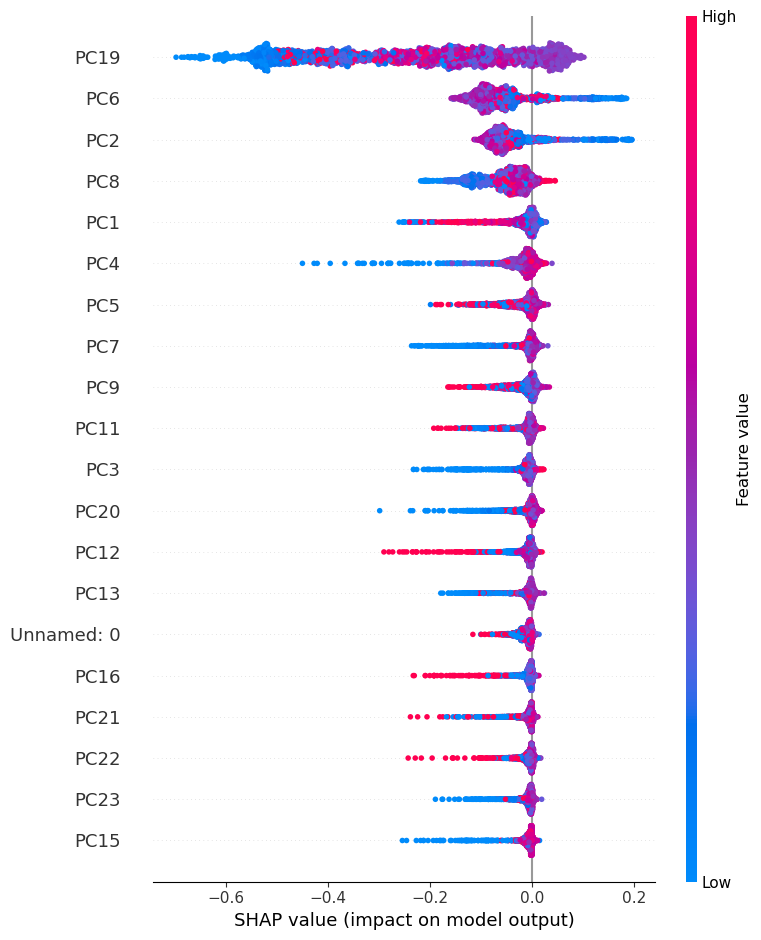

In [12]:
import shap

explainer = shap.TreeExplainer(rf_final)

shap_values = explainer.shap_values(x_test_rf)

shap_values_true = shap_values[:, :, 1]

print(shap_values_true.shape)  # (2333, 24)
print(x_test_rf.shape)         # (2333, 24)

shap.summary_plot(shap_values_true, x_test_rf, feature_names=x_test_rf.columns)

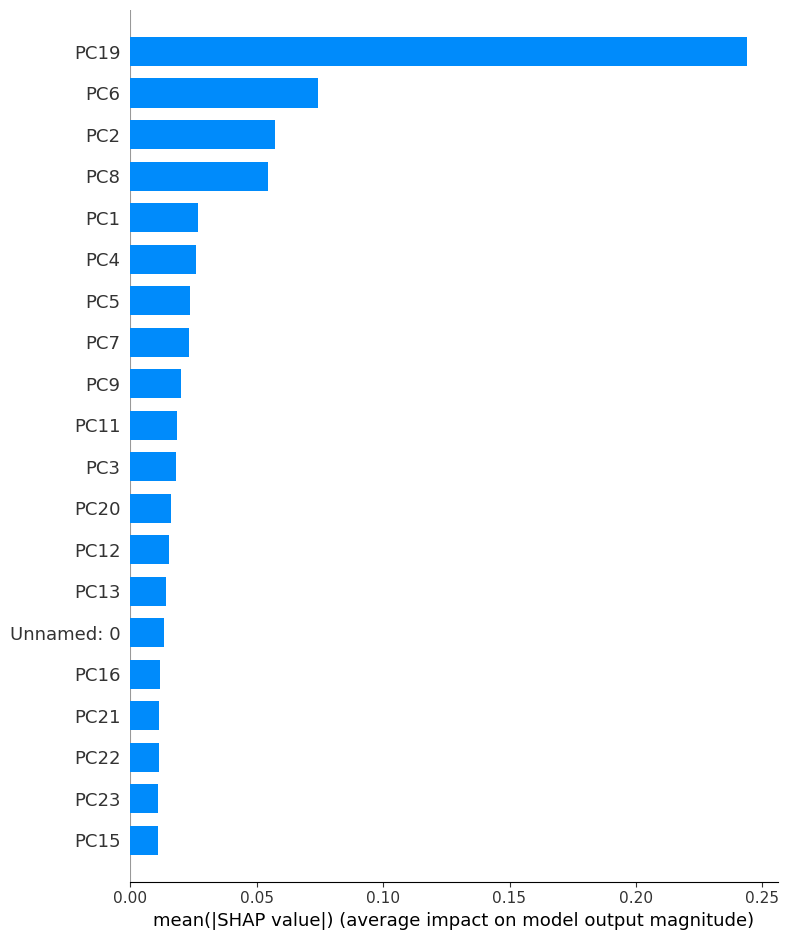

In [13]:



explainer = shap.TreeExplainer(rf_final)


shap_values = explainer.shap_values(x_test_rf)
shap_values_true = shap_values[:, :, 1]


shap.summary_plot(
    shap_values_true,         # SHAP values para la clase Detractor
    x_test_rf,              # Set de test
    feature_names=x_test_rf.columns,
    plot_type='bar'        )



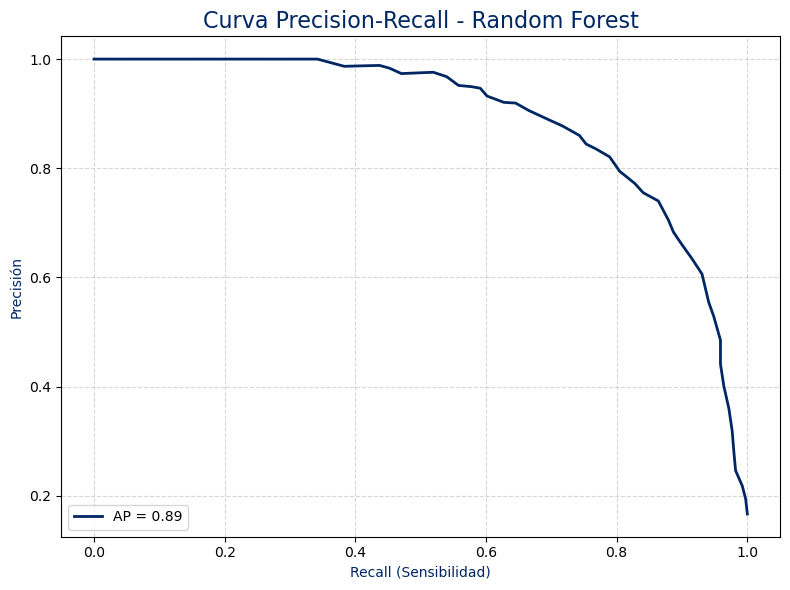

In [14]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calcular curva PR y AUC-PR
precision, recall, thresholds_pr = precision_recall_curve(y_test_rf, y_prob)
ap_score = average_precision_score(y_test_rf, y_prob)

# Graficar curva PR
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='#002663', lw=2, label=f'AP = {ap_score:.2f}')
plt.xlabel('Recall (Sensibilidad)', color='#002663')
plt.ylabel('Precisión', color='#002663')
plt.title('Curva Precision-Recall - Random Forest', fontsize=16, color='#002663')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()
